In [1]:
from typing import Callable, Optional, List
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Canvas

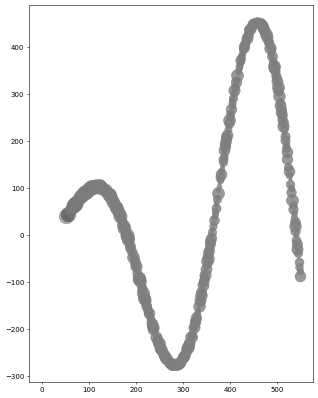

In [27]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

class Canvas:
    def __init__(
        self,
        background: List[int] = [1, 1, 1, 1],
        dimensions: List=(10, 20),
        shake_every: float=0,
        dpi: int = 100,
    ):
        self.background = background
        self.dimensions = dimensions
        self.shake_every = shake_every
        self._figure, self._axes = plt.subplots(figsize=dimensions, dpi=dpi, facecolor=background)
        self.scatter_points([[0.5,0.5]], [background], [0])
        self._frame = self.frame

    def scatter_points(self, points: List[List[int]], colors: List[List[int]], sizes: List[int]):
        for point,color,size in zip(points, colors, sizes):
            self._axes.scatter(point[0], point[1], color=color, s=size)
            self._axes.set_facecolor(self.background)
            self._axes.set_aspect('equal')
            
        self._figure.canvas.draw()
        
    
        
    @property
    def frame(self):
        return self._figure.canvas.renderer.buffer_rgba()      
        # return self._canvas.astype(np.uint8)
canvas = Canvas(background=[1, 1, 1], dimensions=(10, 10), dpi=50)

x_orig = 50
y_orig = 50
rad_orig = 500
x_update = lambda x, t: x+t #np.random.randomnp.random.choice([-1, 1, 0]) #np.sin(t*x)/(x*t)
y_update = lambda x,t: (x+t)*np.sin((x+t)*np.pi/180)#np.random.choice([-1, 1, 0]) #np.sin(t*x)/(x*t)
rad_update = lambda x,t: max(300, x-t) *np.random.random()# np.random.choice([-1, 1, 0]) #np.sin(t)
color_orig = [0.5, 0.5, 0.5, 0.8]
color_update = lambda x,t: x-x/t

pts = 500

coord = [(x_update(x_orig, i), y_update(y_orig, i)) for i in range(1, pts)]
rad = [rad_update(rad_orig, i) for i in range(1, pts)]
color = [[color_update(c, i) for c in color_orig] for i in range(1, pts)]
canvas.scatter_points(coord, color, rad)

0.9999996829318346

## Particle

In [44]:
from dataclasses import dataclass, field
from typing import Callable, List, Optional
import numpy as np

@dataclass
class Particle:
    x: int = 100
    y: int = 100
    z: int = 1
    x_update: Optional[Callable] = field(default=lambda x, t: x +t)
    y_update: Optional[Callable] = field(default=lambda x, t: x * np.cos((x+t)*np.pi/180))
    z_update: Optional[Callable] = field(default=lambda x, t: x-t/(x+2))
    lifespan: int = 100
    color: List[int] = field(default_factory=lambda: [200, 200, 200])
    color_update: Optional[List[Callable]] = field(default_factory=lambda: [lambda x, t: min(max(0, x - t), 255)])
    num_subparticles: Optional[int] = 2
    subparticles_every: Optional[int] = 2
    _time: int = 0
    _current_color: List[int] = field(init=False, default_factory=lambda: [200, 200, 200])
    _position: List[int] = field(init=False, default_factory=lambda: [100, 100, 2])
    is_alive: bool = True

    def update_position(self, time: float):
        x = self.x if self.x_update is None else self.x_update(self.x, time)
        y = self.y if self.y_update is None else self.y_update(self.y, time)
        z = self.z if self.z_update is None else self.z_update(self.z, time)

        return [x, y, z]

    def update_color(self, time: float):
        color = self.color
        if self.color_update is None:
            pass
        elif len(self.color_update) == 1:
            fxn = self.color_update[0]
            color = [fxn(c, time) for c in color]
        else:
            color = [upd(c, time) for upd, c in zip(self.color_update, color)]
        return [int(c) for c in color]

    def update(self):
        
        sub_particles = []
        if self._time <= self.lifespan:
            self._position = self.update_position(self._time)
            self._current_color = self.update_color(self._time)
            sub_particles = [self]
            
            if self._time % self.subparticles_every == 0:
                if self.num_subparticles is not None:
                    for p in range(self.num_subparticles):
                        p = Particle(
                            self._position[0],
                            self._position[1],
                            self._position[2],
                            self.x_update,
                            self.y_update,
                            self.z_update,
                            self.lifespan,
                            self._current_color,
                            self.color_update,
                            self.num_subparticles,
                            self.subparticles_every / ,
                        )
                        sub_particles.append(p)
        else:
            self.is_alive = False
        self._time += 1
        return sub_particles

# Example usage:
particle = Particle()
particle.update()
print(particle)


Particle(x=100, y=100, z=1, x_update=<function Particle.<lambda> at 0x00000196E2730AF0>, y_update=<function Particle.<lambda> at 0x00000196E2730B80>, z_update=<function Particle.<lambda> at 0x00000196E2730C10>, lifespan=100, color=[200, 200, 200], color_update=[<function Particle.<lambda>.<locals>.<lambda> at 0x00000196E2730A60>], num_subparticles=2, subparticles_every=50, _time=0, _current_color=[200, 200, 200], _position=[100, 100, 2], is_alive=True)


## Smoke

In [60]:
class Smoke:
    def __init__(
        self,
        origin: List = [(100, 100)],
        lifespan: int = 1000,
        start_particles: int = 10,
    ):
        self.origin = origin
        self.lifespan = lifespan
        self.start_particles = start_particles
        self.particles: Optional[List[Particle]] = []
        self._time = 0
        self.is_alive = True
        self._startup()
    
    @property
    def num_particles(self):
        return len(self.particles)

    def _startup(self):
        for sp in range(self.start_particles):
            p = Particle(
                x=self.origin[0][0]+np.random.randint(-10, 10),
                y=self.origin[0][1]+np.random.randint(-10, 10),
                z=20,
                x_update=lambda x, t: x + np.random.choice([-1, 1, 0]),
                y_update=lambda x, t: x*np.sin((t+x)*np.pi/180),
                num_subparticles=np.random.randint(1,5),
                subparticles_every=2)
            self.particles.append(p)

    def update(self):
        
        temp_particles = []
        if self.lifespan >= self._time:
            for particle in self.particles:
                res = particle.update()
                if len(res) > 0:
                    temp_particles.extend(res)
                if not particle.is_alive:
                    del particle
                else:
                    temp_particles.append(particle)
        else:
            self.is_alive = False
        self.particles = temp_particles
        self._time += 1
        return self.particles


In [61]:
smoke = Smoke()

for i in range(5):
    smoke.update()
    print(smoke.num_particles)
    smoke.update()
    print(smoke.num_particles)

10
32
32
112
112
428
428
1768
1768
7772


In [ ]:







class PlayGround:
    def __init__(
        self, max_frames: int = 1000, smoke_origins: List = [(350, 500), (200, 200)]
    ):
        self.max_frames = max_frames
        self.smoke_origins = smoke_origins
        self.canvas = Canvas(
            255 + np.zeros((700, 1000, 3), dtype=np.uint8),
            dimensions=[400, 500],
            shake_every=0,
        )
        self.smokes = [Smoke(orig) for orig in smoke_origins]
        self.current_frame = 0
        self.is_alive = True

    @property
    def frame(self):
        return self.canvas.frame

    def update_frame(self, smoke: Smoke):
        for particle in smoke.particles:
            x, y, z = [int(v) for v in particle._position]
            color = tuple([int(c) for c in particle._current_color])
            self.canvas.draw_circle((y, x), z, color)

    def update(self):
        temp_smokes = []
        if self.current_frame <= self.max_frames:
            for smoke in self.smokes:
                if not smoke.is_alive:
                    del smoke
                else:
                    temp_smokes.append(smoke)
                smoke.update()
                self.update_frame(smoke)
        else:
            self.is_alive = False
        return self.frame


pg = PlayGround()
while True:
    cv2.imshow("Canvas", pg.frame.astype(np.uint8))
    pg.update()
    key = cv2.waitKey(20)

    if key == ord("q") or not pg.is_alive:
        break

cv2.destroyAllWindows()